In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import pickle
import matplotlib.pyplot as plt #import matplotlib as plot
from datetime import datetime, timedelta
from imblearn import over_sampling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score,fbeta_score, log_loss, confusion_matrix, roc_auc_score, roc_curve, fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from mlxtend.classifier import StackingClassifier 

#saving
#pickle.dump(master_df, open("master_df.pickle", "wb" ))

#reading df
#master_df=pickle.load(open("master_df.pickle", "rb"))


plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

pd.options.display.max_rows = 251


# Importing 

In [317]:
#neuropysch
neuropsych_df=pd.read_excel('mac_neuropsych.xlsx', sheet_name='mac_neuropsychmmse',
                           index_col=0)
#loose mask for filtering data with nulls
neuropsych_df=neuropsych_df[neuropsych_df['MMSETot']>=0]

In [318]:
#additional neuropsych
bedside_df=pd.read_excel ('mac_query.xlsx',
                          sheet_name='mac_bedsidescreen', index_col=0)
#masking data with nulls 
bedside_df=bedside_df[bedside_df['MMSETot']>=0]

In [319]:
#demographics
demo_df=pd.read_excel('mac_demo.xlsx', index_col=0)

In [320]:
#clinical dementia rating 
cdr_df=pd.read_excel('mac_cdr.xlsx', index_col=0)

In [321]:
#diagnosis 
dx_df=pd.read_excel ('mac_dxl.xlsx', sheet_name='mac_diagnosis', index_col=0)

# Filtering and merging

In [428]:
#can read in pickles instead of running importing chunks
neuropsych_df=pickle.load(open("neuropsych_df.pickle", "rb"))
bedside_df=pickle.load(open("bedside_df.pickle", "rb"))
demo_df=pickle.load(open("demo_df.pickle", "rb"))
cdr_df=pickle.load(open("cdr_df.pickle", "rb"))
dx_df=pickle.load(open("dx_df.pickle", "rb"))


In [429]:
#selecting only date and mmse data columns
col_names=list(bedside_df.iloc[:, np.r_[1, 15:44]].columns)

#masking to merge two datasets with mmse data and saved as mmse_df
mmse_df=neuropsych_df[col_names]
mmse_df=mmse_df.append(bedside_df[col_names])
mmse_df.shape

(32813, 30)

In [430]:
#saving cdr df as w only relevant columns
cdr_df=cdr_df[['DCDate','CDRTot']]
#finding those that are healthy but without a cdr score
norms=pd.DataFrame(dx_df[(dx_df['NORMAL']==5)|
            (dx_df['ClinSynBestEst']=='CLINICALLY NORMAL')|
            (dx_df['DxPrim']=='NORMAL')|
            (dx_df['Level1']=='NORMAL')|
            (dx_df['Level2']=='NORMAL')|
            (dx_df['Level3']=='NORMAL')|
            (dx_df['Level4']=='NORMAL')|
            (dx_df['Level5']=='NORMAL')|
            (dx_df['ResDxA']=='RECRUITED CONTROL NORMAL')]['DCDate'])
#merging the cdr and norms 
norms=pd.merge(cdr_df, norms, on = 'PIDN')

#filtering to only those where the data entries fall within 90 days-we can't assume that someone has the same cdr score at a different date
norms=norms[pd.to_datetime(norms.DCDate_x)-pd.to_datetime(norms.DCDate_y)<pd.Timedelta(90,'d')]



In [431]:

#setting cdr to zero for those that had a label of 'normal' if the cdr score is missing or if the cdr is negative(this also means the data were missing)
norms.loc[(norms['CDRTot']<0)|(norms['CDRTot'].isna()),'CDRTot']= 0

#renaming the date column we'll keep
norms=norms.iloc[:,0:2].rename(columns={'DCDate_x':'DCDate'})
#appending the norms dataframe to the cdr data frame
cdr_df=cdr_df.append(norms)
#dropping all data who do not have a cdr score or a negative cdr score (those were set to zero)
cdr_df=cdr_df[cdr_df['CDRTot']>=0].dropna()

#merging the mmse data to the newly modified df
master_df=pd.merge(mmse_df, cdr_df, on='PIDN', how='inner')
#keep only the data that matches date of the other dataframe's date

#drop this data since date was out of range
master_df.drop(index=32208, inplace=True)



In [432]:
master_df=master_df[pd.to_datetime(master_df.DCDate_x)-pd.to_datetime(master_df.DCDate_y)<pd.Timedelta(180,'d')]


In [433]:
longitudinal_df=master_df.drop_duplicates()

master_df=master_df.drop_duplicates().groupby('PIDN').last()


In [434]:
#merge master df and demographics df together
master_df=pd.merge(master_df,demo_df.iloc[:, np.r_[0,4:7]], on='PIDN')

In [435]:
#convert dob to datetime
master_df['DOB']=pd.to_datetime(master_df['DOB'])
#get diff from data collection date form bday and convert to years
master_df['age']=(master_df['DCDate_x']-master_df['DOB']) / np.timedelta64(1, 'Y')

In [436]:
master_df=master_df.dropna()

In [437]:
master_df=master_df.drop(['DCDate_x', 'DCDate_y', 'MMSETotalOnly', 'DOB'], axis=1)


In [438]:
#remove spaces
master_df['Hand']=master_df['Hand'].str.strip()

In [439]:
master_df["Hand"] = master_df["Hand"].astype('category')
#dementia score of 1 has dementia
master_df.loc[master_df['CDRTot']>=.5, 'Dementia']=1
master_df['Dementia']=master_df['Dementia'].fillna(0)
master_df['Dementia']=master_df['Dementia'].astype('category').cat.codes



In [440]:
master_df['Dementia']=master_df['Dementia'].fillna(0)

In [441]:
#2-right, 1-left,0-amb
master_df['Hand']=master_df["Hand"].cat.codes

In [442]:
#removing CDR scores as we're now using a binary classification of dementia, which was derived from this score
master_df.drop(['CDRTot'], axis=1, inplace=True)

# removing all data that has negative values-this will mess things up for naive bayes model 
master_df=master_df[master_df.select_dtypes(include=[np.number]).ge(0).all(1)]



## Load in dfs to use

In [272]:
####
#Load in the master_df pickle
####

master_df=pickle.load(open("master_df.pickle", "rb"))
#longitudinal_df=pickle.laod(open('longitudinal_df.pickle', 'rb'))

#Anyonymizing indices 
master_df.set_index([pd.Index(list(range(len(master_df))))], inplace=True)


# EDA

In [526]:
from bokeh.palettes import Colorblind
from bokeh.plotting import figure, show
from bokeh.transform import cumsum
from math import pi
from bokeh.io import export_png,export_svg
from bokeh.plotting import figure
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())




#proportion of positive and negative target features... more data with dementia than without. 
master_df['Dementia'].value_counts(1)

pie_values=master_df['Dementia'].value_counts()
pct_norm='{:.1%}'.format(master_df['Dementia'].value_counts(1)[0])
pct_dem='{:.1%}'.format(master_df['Dementia'].value_counts(1)[1])
pcts={'Cogntively Normal':'{:.1%}'.format(pie_values[0]),'Dementia':'{:.1%}'.format(pie_values[1])}
pie_values={'Cogntively Normal':[pie_values[0],pct_norm],
            'Dementia':[pie_values[1],pct_dem]}




data=pd.Series(pie_values).reset_index(name='value').rename(columns={'index': 'Group'})
data['pct']=pd.Series([cnt[1] for cnt in data['value']])


#data = pd.Series(x).reset_index(name='value').rename(columns={'index': 'country'})
data['angle'] = pd.Series([cnt[0] for cnt in data['value']])/pd.Series([cnt[0] for cnt in data['value']]).sum() * 2*pi
data['color'] = ('#0072B2', '#E69F00')

p = figure(height=350, title="Group Size", toolbar_location=None,
           tools="hover", tooltips="@Group: @pct", x_range=(-0.5, 1.0))
p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='Group', source=data)
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None
export_svg(p, filename="groups.svg")
show(p)



====== WebDriver manager ======
Current google-chrome version is 95.0.4638
Get LATEST chromedriver version for 95.0.4638 google-chrome
Driver [/Users/ClaytonYoung/.wdm/drivers/chromedriver/mac64/95.0.4638.69/chromedriver] found in cache


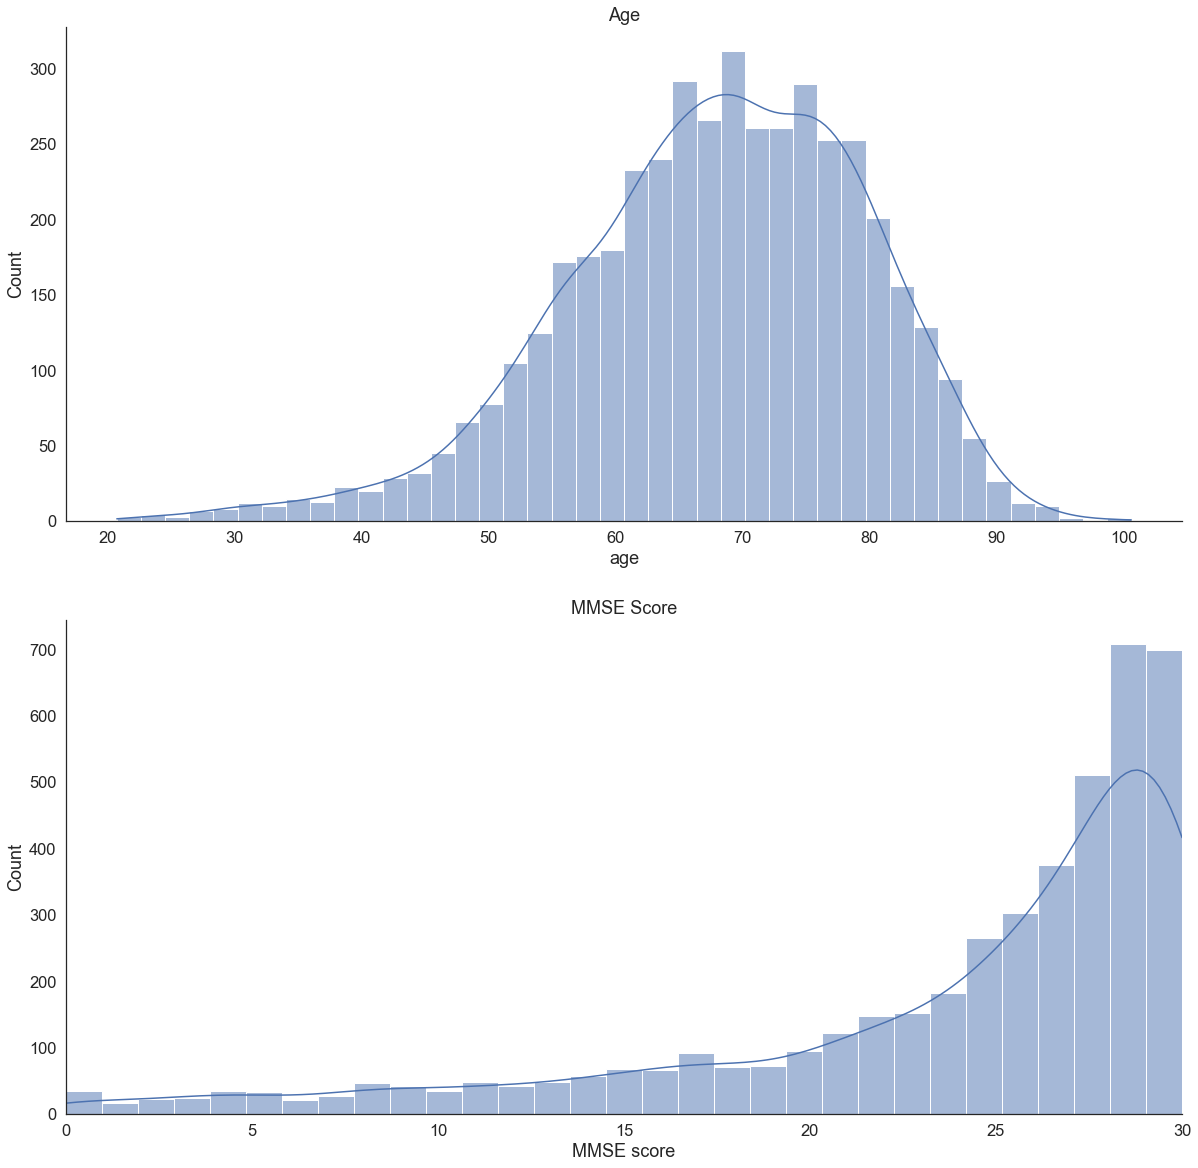

In [528]:
#set theme to blank backgroun and increase font size
sns.set_theme(style= "white", font_scale=1.5)
#set up subplot 
fig, axes = plt.subplots(2, 1, figsize=(20, 20))
#remove ugly borders
sns.despine()
#plot age
plt.xlim(0,100)
plt.xlabel('Age')
plt.ylabel('Count')
sns.histplot(master_df['age'],kde=True,ax=axes[0])
axes[0].title.set_text('Age')
#plot mmse scores
plt.xlim(0,30)
plt.xlabel('MMSE score')
plt.ylabel('Count')
sns.histplot(master_df['MMSETot'],kde=True, ax=axes[1])
axes[1].title.set_text('MMSE Score')



# Model prep

In [277]:
scaler = StandardScaler()
X=master_df.iloc[:,:-1]
y=master_df['Dementia']
#get column names to pass into pipes
col_names=X.columns

## define the data preparation for the model that need scaled data
t = [('scaler', StandardScaler(), col_names)]
col_transform = ColumnTransformer(transformers=t,remainder='passthrough')

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

#temp val split-will overwrite the train data with above split before cross val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                       test_size=.25,     
                                       random_state=42)


#Using this to score models during hyperparameter tuning
ftwo_scorer = make_scorer(fbeta_score, beta=2)

## kNN

In [156]:
knn_model = KNeighborsClassifier(n_neighbors= 50, p= 1, weights= 'uniform')
# define the data preparation and modeling pipeline
knn = Pipeline(steps=[('prep',col_transform), ('m', knn_model)])

#fit model 
knn.fit(X_train,y_train)

#roc curve
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])


####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
knn_gmeans = np.sqrt(knn_tpr * (1-knn_fpr))
# locate the index of the largest g-mean
knn_ix = np.argmax(knn_gmeans)


# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
#for confusion matrices
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
knn_confusion_threshold = confusion_matrix(y_test, knn.predict_proba(X_test)[:,1]>knn_thresholds[knn_ix])




print('Base training f2:  0.883')
print('Base validation f2:  0.823')
print('')
print("Tuned training f2: {:6.3f}".format(fbeta_score(y_train,knn.predict(X_train), beta=2)))
print("Tuned validation f2: {:6.3f}".format(fbeta_score(y_val,knn.predict(X_val), beta=2)))
y_prob_pred_val = knn.predict_proba(X_val)[:,1]
y_predict = knn.predict(X_val)
print("f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("ROC AUC score: {:6.3}".format(roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (knn_thresholds[knn_ix], knn_gmeans[knn_ix]))


Base training f2:  0.883
Base validation f2:  0.823

Tuned training f2:  0.787
Tuned validation f2:  0.780
f1:  0.824
ROC AUC score:   0.84
Best Threshold=0.480000, G-Mean=0.763


## Logistic regression

[logloss (cross entropy) explanation](https://www.kaggle.com/dansbecker/what-is-log-loss)

In [157]:
# define the model
log_model = LogisticRegression(C=0.01, solver='lbfgs')
# define the data preparation and modeling pipeline
logit = Pipeline(steps=[('prep',col_transform), ('m', log_model)])

#fit model to train data
logit.fit(X_train,y_train)

#for roc plot
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, logit.predict_proba(X_test)[:,1])


####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
log_gmeans = np.sqrt(log_tpr * (1-log_fpr))
# locate the index of the largest g-mean
log_ix = np.argmax(log_gmeans)
#for conf matrices

#for conf matrices
log_confusion = confusion_matrix(y_test, logit.predict(X_test))
log_confusion_threshold = confusion_matrix(y_test, logit.predict_proba(X_test)[:,1]>log_thresholds[log_ix])



print('Base training f2:  0.868')
print('Base validation f2:  0.849')
print('')
print("Tuned training f2: {:6.3f}".format(fbeta_score(y_train,logit.predict(X_train), beta=2)))
print("Tuned validation f2: {:6.3f}".format(fbeta_score(y_val,logit.predict(X_val), beta=2)))
y_prob_pred_val = logit.predict_proba(X_val)[:,1]
y_predict = logit.predict(X_val)
print("f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("ROC AUC score: {:6.3}".format(roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (log_thresholds[log_ix], log_gmeans[log_ix]))

Base training f2:  0.868
Base validation f2:  0.849

Tuned training f2:  0.877
Tuned validation f2:  0.865
f1:  0.852
ROC AUC score:  0.848
Best Threshold=0.649884, G-Mean=0.768


# Tree models

In [158]:

randomforest = RandomForestClassifier(bootstrap=True,
                                      max_depth= 5, 
                                      max_features= 'auto',
                                      n_estimators= 50)

randomforest.fit(X_train,y_train)



#roc curve
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_test, randomforest.predict_proba(X_test)[:,1])

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
forest_gmeans = np.sqrt(forest_tpr * (1-forest_fpr))
# locate the index of the largest g-mean
forest_ix = np.argmax(forest_gmeans)


#confusion matrix w/threshold
forest_confusion_threshold = confusion_matrix(y_test, 
                                              randomforest.predict_proba(X_test)[:,1]>forest_thresholds[forest_ix])
#confusion matrix 
forest_confusion = confusion_matrix(y_test, randomforest.predict(X_test))



print("Base training f2: 1.000")
print("Base validation f2: 0.866")
print('')
print("Tuned training f2: {:6.3f}".format(fbeta_score(y_train,randomforest.predict(X_train), beta=2)))
print("Tuned validation f2: {:6.3f}".format(fbeta_score(y_val,randomforest.predict(X_val), beta=2)))
y_prob_pred_val = randomforest.predict_proba(X_val)[:,1]
y_predict = randomforest.predict(X_val)
print("f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("Tuned ROC AUC score:{:6.3}".format(roc_auc_score(y_test, randomforest.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (forest_thresholds[forest_ix], forest_gmeans[forest_ix]))

Base training f2: 1.000
Base validation f2: 0.866

Tuned training f2:  0.882
Tuned validation f2:  0.874
f1:  0.862
Tuned ROC AUC score: 0.856
Best Threshold=0.666797, G-Mean=0.786


# BOOST

In [159]:
#instantiate boosted model with recommended hps 
gbm = xgb.XGBClassifier(n_estimators=180,
                    max_depth=2,
                    objective='binary:logistic', #new objective
                    learning_rate=.05, 
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8,
                    use_label_encoder=False,
                    gamma=1.5)


eval_set=[(X_train,y_train),(X_val,y_val)]
gbm.fit(X_train, y_train, 
        eval_set=eval_set,
        eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
        early_stopping_rounds=10,
        verbose=False)




#roc curve
gbm_fpr, gbm_tpr, gbm_thresholds = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
gbm_gmeans = np.sqrt(gbm_tpr * (1-gbm_fpr))
# locate the index of the largest g-mean
gbm_ix = np.argmax(gbm_gmeans)


#confusion matrix
boost_confusion_threshold = confusion_matrix(y_test, gbm.predict_proba(X_test)[:,1]>gbm_thresholds[gbm_ix])
boost_confusion = confusion_matrix(y_test, gbm.predict(X_test))




print("Base training f2:  0.893")
print("Base validation f2:  0.865")
print("")
print("Tuned boost training f2: {:6.3f}".format(fbeta_score(y_train,gbm.predict(X_train), beta=2)))
print("Tuned boost validation f2: {:6.3f}".format(fbeta_score(y_val,gbm.predict(X_val), beta=2)))
#calc log loss (1-* likelihood function)
y_prob_pred_val = gbm.predict_proba(X_val)[:,1]
y_predict = gbm.predict(X_val)
print("Tuned f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("Tuned ROC AUC score:{:6.3}".format(roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (gbm_thresholds[gbm_ix], gbm_gmeans[gbm_ix]))

Base training f2:  0.893
Base validation f2:  0.865

Tuned boost training f2:  0.868
Tuned boost validation f2:  0.859
Tuned f1:  0.855
Tuned ROC AUC score: 0.848
Best Threshold=0.663992, G-Mean=0.776


## Ensebling 

In [160]:
model_list=[knn,logit,randomforest,gbm]
model_names = ["knn", "logit", "randomforest", "gbm"]


model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

voting = VotingClassifier(estimators=model_list,
                                    voting='soft',
                                    n_jobs=-1)

voting.fit(X_train, y_train)

fbeta_score(y_val,voting.predict(X_val), beta =2)



#roc curve
voting_fpr, voting_tpr, voting_thresholds = roc_curve(y_test, voting.predict_proba(X_test)[:,1])

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
voting_gmeans = np.sqrt(voting_tpr * (1-voting_fpr))
# locate the index of the largest g-mean
voting_ix = np.argmax(voting_gmeans)


#confusion matrix
voting_confusion_threshold = confusion_matrix(y_test, voting.predict_proba(X_test)[:,1]>voting_thresholds[voting_ix])
voting_confusion = confusion_matrix(y_test, voting.predict(X_test))





print("Voting training f2: {:6.3f}".format(fbeta_score(y_train,voting.predict(X_train), beta=2)))
print("Voting validation f2: {:6.3f}".format(fbeta_score(y_val,voting.predict(X_val), beta=2)))
#calc log loss (1-* likelihood function)
y_prob_pred_val = voting.predict_proba(X_val)[:,1]
y_predict = voting.predict(X_val)
print("Tuned f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("Tuned ROC AUC score:{:6.3}".format(roc_auc_score(y_test, voting.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (voting_thresholds[voting_ix], voting_gmeans[voting_ix]))

Voting training f2:  0.873
Voting validation f2:  0.857
Tuned f1:  0.856
Tuned ROC AUC score: 0.854
Best Threshold=0.612513, G-Mean=0.780


# Plots

kNN ROC AUC score =  0.840
ROC AUC score =  0.848
Random Forest ROC AUC score =  0.856
Boosted ROC AUC score =  0.848
Voting ROC AUC score: 0.854


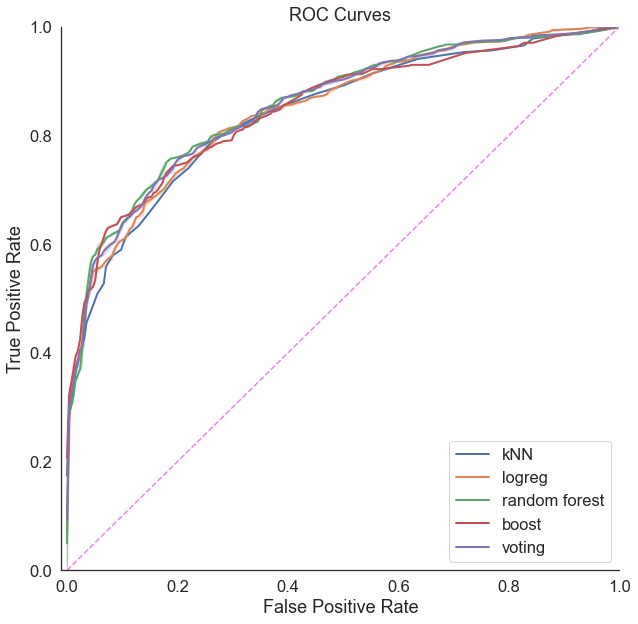

In [327]:
plt.figure(figsize=(10,10))

#kNN
sns.lineplot(x=knn_fpr, y=knn_tpr,lw=2)
# logreg
sns.lineplot(x=log_fpr, y=log_tpr,lw=2)
# random forest
sns.lineplot(x=forest_fpr, y=forest_tpr,lw=2)
#boost
sns.lineplot(x=gbm_fpr, y=gbm_tpr,lw=2)
#voting
sns.lineplot(x=voting_fpr, y=voting_tpr,lw=2)



#linear reference line
plt.plot([0,1],[0,1],c='violet',ls='--')


plt.xlim([-0.01,1.])
plt.ylim([0,1.0])
plt.legend(['kNN','logreg','random forest', 'boost', 'voting'])
sns.despine()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')

plt.savefig('ROC_classification.png')


print("kNN ROC AUC score = {:6.3f}".format(roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])))
print("ROC AUC score = {:6.3}".format(roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])))
print("Random Forest ROC AUC score = {:6.3f}".format(roc_auc_score(y_test, randomforest.predict_proba(X_test)[:,1])))
print("Boosted ROC AUC score = {:6.3f}".format(roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])))
print("Voting ROC AUC score:{:6.3}".format(roc_auc_score(y_test, voting.predict_proba(X_test)[:,1])))





In [162]:
### Did all this before clarification that validation holdout not needed for grid/randomized search CV...
print("Tuned kNN training f2: {:6.3f}".format(fbeta_score(y_train,knn.predict(X_train), beta=2)))
print("Tuned kNN validation f2: {:6.3f}".format(fbeta_score(y_val,knn.predict(X_val), beta=2)))
print('')
print("Tuned logreg training f2: {:6.3f}".format(fbeta_score(y_train,logit.predict(X_train), beta=2)))
print("Tuned logreg validation f2: {:6.3f}".format(fbeta_score(y_val,logit.predict(X_val), beta=2)))
print('')
print("Tuned forest training f2: {:6.3f}".format(fbeta_score(y_train,randomforest.predict(X_train), beta=2)))
print("Tuned forest validation f2: {:6.3f}".format(fbeta_score(y_val,randomforest.predict(X_val), beta=2)))
print('')
print("Tuned boost training f2: {:6.3f}".format(fbeta_score(y_train,gbm.predict(X_train), beta=2)))
print("Tuned boost validation f2: {:6.3f}".format(fbeta_score(y_val,gbm.predict(X_val), beta=2)))
print('')
print("Voting training f2: {:6.3f}".format(fbeta_score(y_train,voting.predict(X_train), beta=2)))
print("Voting validation f2: {:6.3f}".format(fbeta_score(y_val,voting.predict(X_val), beta=2)))
print('')
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("Bayes training f2: {:6.3f}".format(fbeta_score(y_train,clf.predict(X_train), beta=2)))
print("Bayes validation f2: {:6.3f}".format(fbeta_score(y_val,clf.predict(X_val), beta=2)))
print('')
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)
stacked.fit(X_train, y_train)
print("Stacked training f2: {:6.3f}".format(fbeta_score(y_train,stacked.predict(X_train), beta=2)))
print("Stacked validation f2: {:6.3f}".format(fbeta_score(y_val,stacked.predict(X_val), beta=2)))



Tuned kNN training f2:  0.787
Tuned kNN validation f2:  0.780

Tuned logreg training f2:  0.877
Tuned logreg validation f2:  0.865

Tuned forest training f2:  0.882
Tuned forest validation f2:  0.874

Tuned boost training f2:  0.868
Tuned boost validation f2:  0.859

Voting training f2:  0.873
Voting validation f2:  0.857

Bayes training f2:  0.767
Bayes validation f2:  0.736

[16:02:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Stacked training f2:  0.883
Stacked validation f2:  0.870


# Random Forest is the model we'll use

Tuned forest training f2:  0.882
Tuned forest validation f2:  0.874
Tuned forest test f2:  0.872


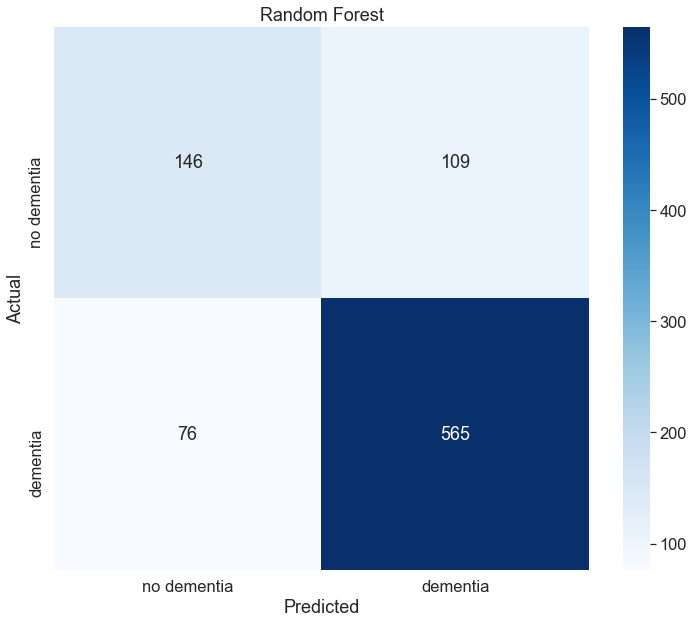

In [326]:
print("Tuned forest training f2: {:6.3f}".format(fbeta_score(y_train,randomforest.predict(X_train), beta=2)))
print("Tuned forest validation f2: {:6.3f}".format(fbeta_score(y_val,randomforest.predict(X_val), beta=2)))
print("Tuned forest test f2: {:6.3f}".format(fbeta_score(y_test,randomforest.predict(X_test), beta=2)))


#forest confusion
plt.figure(figsize=(12,10))

sns.heatmap(forest_confusion, cmap=plt.cm.Blues, annot=True,fmt="d",
           xticklabels=['no dementia', 'dementia'],
           yticklabels=['no dementia', 'dementia'])
plt.title('Random Forest')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('forest_confusion.png')

# Seeing real predictions vs y_test data

In [172]:
temp=random.randrange(len(X_test))
print(temp)
randomforest.predict(X_test)[temp]==y_test.iloc[temp]

513


True